In [1]:
## Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch

## Plotting 
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions

## 
import odor_stat_calculations as osc
import pandas as pd 
import os
import numpy as np

## scipy gaussian regressor 
import scipy
import scipy.stats as stats
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis
from scipy.stats import ks_2samp
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.formula.api as smf
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from concurrent.futures import ProcessPoolExecutor

## bayesian optimization 
from skopt import gp_minimize
from skopt.space import Real, Categorical
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import accuracy_score, classification_report
from mpl_toolkits.axes_grid1 import make_axes_locatable 

from joblib import load, dump

In [53]:
df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5')

In [54]:
distance_min = 0
distance_max = 10
nearest_min = -2
nearest_max = 2

data = df[
    (df['distance_along_streakline'] >= distance_min) &
    (df['distance_along_streakline'] < distance_max) &
    (df['nearest_from_streakline'] >= nearest_min) &
    (df['nearest_from_streakline'] < nearest_max)
]

In [40]:
query = 'odor>2'
df_new=data.query(query)

In [41]:
df_new.reset_index(inplace=True, drop=True) 

Text(0, 0.5, 'Nearest From Streakline')

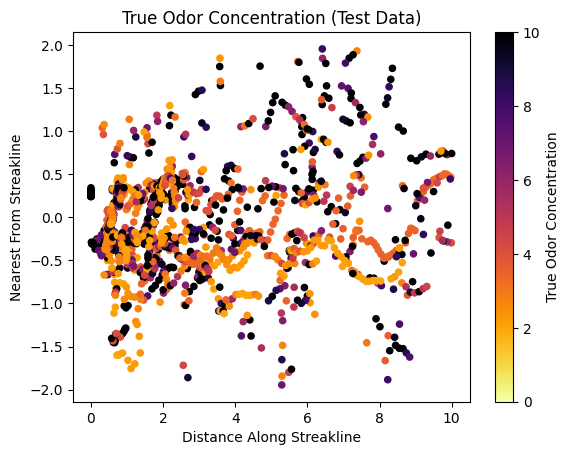

In [42]:
plt.scatter(df_new['distance_along_streakline'], df_new['nearest_from_streakline'], c=df_new['odor'], cmap='inferno_r', s=20, vmin=0, vmax=10)
plt.colorbar(label='True Odor Concentration')
plt.title('True Odor Concentration (Test Data)')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')


In [55]:
data.reset_index(inplace=True, drop=True) 

In [ ]:

def fit_exponential_distribution(far_data, threshold):
    non_saturated_data = far_data[far_data['odor'] < threshold]['odor']
    loc, scale = stats.expon.fit(non_saturated_data)
    return loc, scale

loc, scale = fit_exponential_distribution(far_data, saturation_threshold)

def generate_values_above_threshold(loc, scale, threshold, size):
    cdf_threshold = stats.expon.cdf(threshold, loc=loc, scale=scale)
    uniform_values = np.random.uniform(cdf_threshold, 1, size)
    values_above_threshold = stats.expon.ppf(uniform_values, loc=loc, scale=scale)
    return values_above_threshold

def estimate_values_with_exponential_distribution(df, threshold, loc, scale):
    saturated_indices = df[df['odor'] >= threshold].index
    estimated_values = generate_values_above_threshold(loc, scale, threshold, len(saturated_indices))
    df.loc[saturated_indices, 'odor'] = estimated_values
    return df

# Apply the correction
df_corrected = estimate_values_with_exponential_distribution(df_extracted.copy(), saturation_threshold, loc, scale)
new_test_df = df_extracted.copy()
new_test_df['corrected_odor'] = estimate_values_with_exponential_distribution(new_test_df.copy(), saturation_threshold, loc, scale)['odor']

In [ ]:
# Training the GPR with transformed data
X = df_corrected[['distance_along_streakline', 'nearest_from_streakline']].values
y_transformed = df_corrected['odor_transformed'].values.reshape(-1, 1)

use_scaler = True  
if use_scaler:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
else:
    scaler = None
    X_scaled = X

lengthscale=0.1

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y_transformed).flatten()

# Define the kernel for the Gaussian Process Regressor
# kernel = C(0.814**2, (1e-2, 1e2)) * RBF(lengthscale, (1e-2, 1e1)) 
kernel = C(0.814**2, (1e-2, 1e2)) * (RBF(lengthscale, (1e-2, 1e1)) + Matern(length_scale=lengthscale, nu=0.5))

alpha = 0.263

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=alpha)
gp.fit(X_scaled, y_scaled)

trained_model = gp
trained_scaler = scaler
trained_target_scaler = target_scaler
print(gp.kernel_)
print("Spatial Model Training Done")
